#### Install `Dribble` and its requirements

In [ ]:
try:
    import dribble
except ImportError:
    %pip install git+https://github.com/atomisticnet/dribble.git

# Accessible Sites

Even though a structure is percolating, not all sites are necessarily connected to the network of percolating diffusion pathways.  Dribble can compute the fraction of occupied sites that is isolated, or *inaccessible*, within a percolating structure.

## Input File

Here, we will determine the fraction of accessible sites for the nearest-neighbor site percolation problem of [Example 0](../00-Command-Line-Usage/example00.ipynb). Once again, the same general input file can be used:

In [1]:
%%writefile input-bond-rule.json
{
    "structure": "Cu-fcc.vasp",
    "formula_units": 1.0,
    "sublattices": {
        "A": {
            "description": "Copper sites",
            "sites": {"species": ["Cu"]},
            "initial_occupancy": {"Vac": 1.0}
        }
    },
    "bonds": [
        {
            "sublattices": ["A", "A"],
            "bond_rules": [["NearestNeighborBR"]]
        }
    ],
    "percolating_species": ["Cu"],
    "flip_sequence": [["Vac", "Cu"]]
}

Overwriting input-bond-rule.json


In [ ]:
%%writefile Cu-fcc.vasp
FCC Structure
3.6
     0.0      0.5      0.5
     0.5      0.0      0.5
     0.5      0.5      0.0
Cu
1
direct
     0.0      0.0      0.0 Cu

See [Example 0](../00-Command-Line-Usage/example00.ipynb) for a detailed discussion of the input file.

## Calculation using the Command Line Tool

The fraction of **inaccessible sites** is computed by `Dribble`'s command line tool if the `-i` (or `--inaccessible`) flag is present **followed by the atomic species** for which the quantity shall be evaluated ("Cu" in our simple site percolation example).  Once again, care has to be taken to select a sufficiently large supercell:

In [2]:
! dribble input-bond-rule.json --supercell 10 10 10 -i Cu


 Parsing input file 'input-bond-rule.json'... done.

 Setting up lattice and neighbor lists... done.

 Lattice and Sites
 -----------------

 Lattice vectors:

     0.00000000   18.00000000   18.00000000
    18.00000000    0.00000000   18.00000000
    18.00000000   18.00000000    0.00000000

 total number of sites : 1000
 occupied sites        : 0 (0 static)
 vacant sites          : 1000 (0 static)
 number of NNs         : 12

 Neighbor List
 -------------

 interaction range          : NNs only
 boxes per lattice direction: 5 5 5
 total number of atoms      : 1000
 av. number of atoms per box: 8.0

 Initializing percolator... done.

 MC percolation simulation
 -------------------------

 Calculating fraction of inaccessible Cu sites.
 Averaging over 500 samples:

 0%                25%                 50%                 75%                 100%
 ▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮ done.

 Return convolution with a binomial distribution.



**Note:** The calculation of inaccessible sites is significantly more time consuming than the calculation of the periodic wrapping probability of [Example 3](../03-Wrapping-Probability/example03.ipynb), since all occupied sites have to be considered at each concentration (not just the sites within percolating clusters).

Per default, `Dribble` returns a binomial convolution of the Monte Carlo results which helps to improve convergence with the number of Monte Carlo samples (500 per default).  These results are written to a file named `percol.inacc`.  The raw data can be requested with the flag `--save-raw`.

Let's take a look at the generated output file:

In [3]:
!head percol.inacc

#     p        F_inacc(p)   N_percol(p)
  0.01000000   0.99995683       0.000000
  0.02000000   1.00000000       0.000000
  0.03000000   1.00000000       0.000000
  0.04000000   1.00000000       0.000000
  0.05000000   1.00000000       0.000000
  0.06000000   1.00000000       0.000000
  0.07000000   1.00000000       0.000000
  0.08000000   1.00000000       0.000000
  0.09000000   1.00000000       0.000000


The first column in the output file contains the relative site occupancy, i.e., the fraction of sites that is occupied.  The second column gives the fraction of occupied sites that are *inaccessible*, i.e., not connected to percolating diffusion pathways.  As you can see, there is some numerical noise present.  And the third column is the the number of percolating domains (or *clusters*) divided by the total number of independent domains, i.e., the fraction of percolating clusters out of all clusters.

Let's plot the quantities:

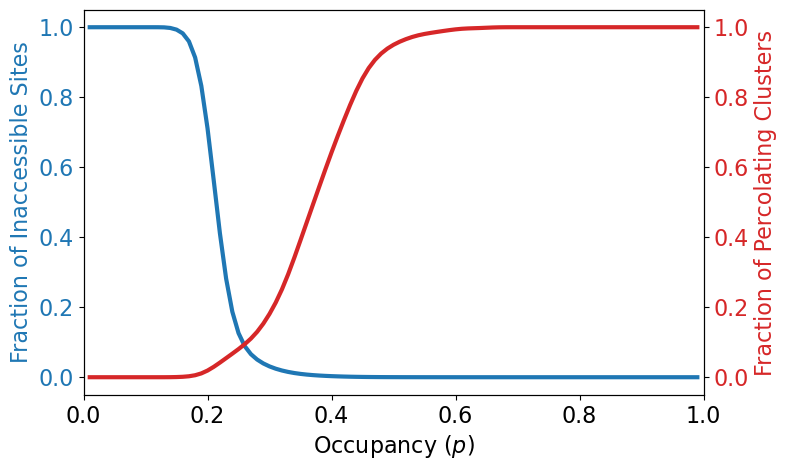

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
data = np.loadtxt("percol.inacc")
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(0,1)
ax.set_xlabel("Occupancy ($p$)", fontsize=16)
ax.set_ylabel(r"Fraction of Inaccessible Sites", fontsize=16, color="tab:blue")
ax.tick_params(labelsize=16)
ax.tick_params(axis='y', labelcolor="tab:blue")

ax2 = ax.twinx()
ax2.set_ylabel(r"Fraction of Percolating Clusters", fontsize=16, color="tab:red")
ax2.tick_params(labelsize=16, labelcolor="tab:red")

ax.plot(data[:,0], data[:,1], linewidth=3, color="tab:blue")
ax2.plot(data[:,0], data[:,2], linewidth=3, color="tab:red")
plt.show()

As seen in the plot, the fraction of inaccessible sites approaches zero much faster than the fraction of percolating clusters, as even a single isolated site counts as an independent *cluster*.

We can replot the same data to visualize the overall fraction of sites $f_a$ (relative to all sites, not only the occupied ones) that become accessible at a given concentration of occupied sites $x$

\begin{equation}
  f_a(x) = x\,\left[1-r_i(x)\right]
\end{equation}

where $r_i(x)$ is the fraction of inaccessible occupied sites plotted above in blue.

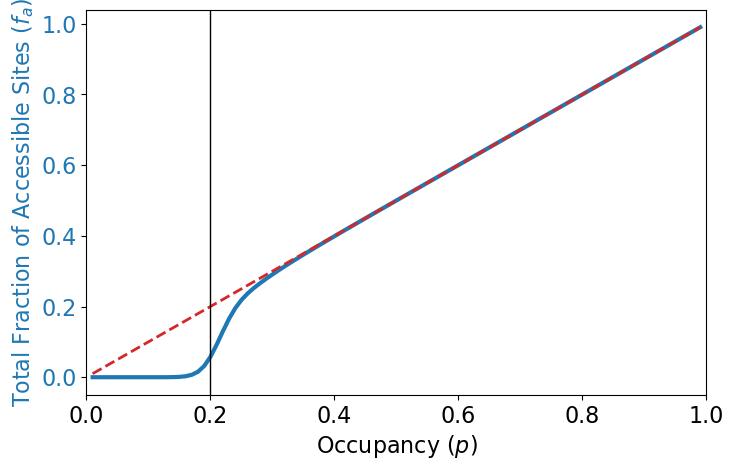

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
data = np.loadtxt("percol.inacc")
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(0,1)
ax.set_xlabel("Occupancy ($p$)", fontsize=16)
ax.set_ylabel(r"Total Fraction of Accessible Sites ($f_a$)", fontsize=16, color="tab:blue")
ax.tick_params(labelsize=16)
ax.tick_params(axis='y', labelcolor="tab:blue")
x = data[:,0]
r_i = data[:,1]
f_a = x*(1-r_i)
ax.plot(x, f_a, linewidth=3, color="tab:blue")
ax.plot(x, x, linewidth=2, color="tab:red", ls="--")
ax.axvline(0.199, linewidth=1, color="black")
plt.show()

In the above plot, the black vertical line indicates the (converged) percolation threshold of $x_c\approx{}0.199$, and the red dashed line is the total amount of occupied sites.  The area between the red dashed line and the blue line corresponds to the occupied sites that are inaccessible.